# Анализ алгоритмов замещения страниц оперативной памяти

## Введение

В основе алгоритмов замещения страниц оперативной памяти лежит выбор, какую же из загруженных на текущий момент страниц выбрать для замещения. В ходе данной работы были изучены различные подходы к выбору страницы для замещения, такие как:
1. FIFO для замещения выбирает страницу, которая была загружена в память раньше всех.
2. LRU для замещения выбирает страницу, к которой дольше всего не было обращений.
3. CLOCK для замещение выбирает страницу, следующую в циклическом буфере, у которой бит использования выставлен в 0 (подробнее про алгоритм можно прочитать здесь: https://stepik.org/lesson/633809/step/4?unit=630582)
4. RAND для заещения выбирает случайную страницу. 
5. OPT для замещения выбирает страницу, которая дольше всех не будет использована в будущем. Данный алгоритм оптимален с точки зрения числа страничных ошибок, однако, к сожалению, не реализуем на практике, т.к. использует данные о будущих запросах.

## Описание эксперимента

В ходе работы были реализованы и сравнены предложенные выше алгоритмы. Для сравнения алгоритмов был построен датасет из 300 запусков алгоритмов на случаных данных. Каждый раз алгоритмы запускались на данных, где количество кадров опреативной памяти -- случайное число от 1 до 1000, число страничных запросов также случайно от 1 до 100.000, а номера страниц -- случайные числа от 1 до 10.000. По результатам запуска каждого из алгоритмов в таблицу были записаны число страничных ошибок, которое выдал этот алгоритм и время его работы. Данные были сохранены в файле benchmarks.csv

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('benchmarks.csv')

In [3]:
df.shape

(300, 12)

In [4]:
df.head(5)

,num frames,num requests,OPT errors,OPT time,FIFO errors,FIFO time,LRU errors,LRU time,CLOCK errors,CLOCK time,RAND errors,RAND time
0,412,96815,71272,57,92835,33,92819,86,92841,35,92841,40
1,759,11123,7849,6,10317,3,10331,9,10330,3,10368,4
2,268,94472,74220,51,91961,29,91958,79,91965,31,91937,37
3,851,68784,43430,40,62837,22,62845,64,62822,24,62876,28
4,709,70077,46221,42,65160,23,65163,65,65163,24,65104,28


Первое, что хочется оценить -- это процент страничных ошибок в зависимости числа свободных кадров. Из графика ниже видно, что все алгоритмы, кроме оптимального, ведут себя очень похоже, что может говорить о том, что в целом для случайных данных выбор алгоритма не влияет на число страничных ошибок.

При этом также можно заметить, что с ростом числа кадров оперативной памяти, процент ошибок снижается. Хотя не всегда в строгости верно, что при увеличении числа кадров уменьшается число страничных ошибок, в среднем доля ошибок убывает с ростом опреативной памяти, так как больше кадров удается держать в памяти.

При этом видно также, что тренд убывания процента страничных ошибок линейный для всех алгоритмов, кроме оптимального. Для оптимального алгоритма тренд имеет несколько более сложную форму. Однако если приблизить его линейной функцией, коэффициент убывания будет значительно больше, чем у остальных алгоритмов.

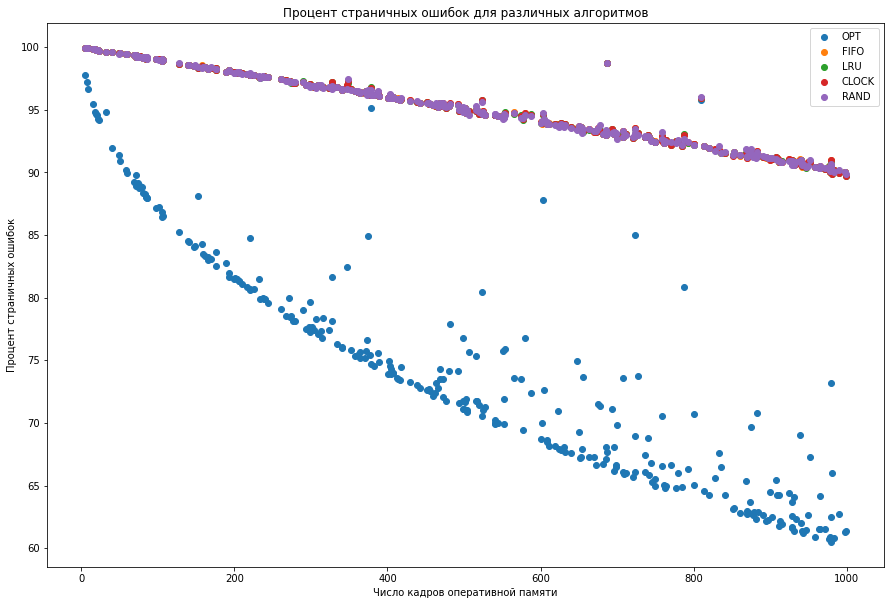

In [5]:
plt.subplots(figsize=(15,10))
plt.plot(df['num frames'], 100 * df['OPT errors'] / df['num requests'], 'o', label='OPT')
plt.plot(df['num frames'], 100 * df['FIFO errors'] / df['num requests'], 'o', label='FIFO')
plt.plot(df['num frames'], 100 * df['LRU errors'] / df['num requests'], 'o', label='LRU')
plt.plot(df['num frames'], 100 * df['CLOCK errors'] / df['num requests'], 'o', label='CLOCK')
plt.plot(df['num frames'], 100 * df['RAND errors'] / df['num requests'], 'o', label='RAND')
plt.legend()
plt.xlabel('Число кадров оперативной памяти')
plt.ylabel('Процент страничных ошибок')
plt.title('Процент страничных ошибок для различных алгоритмов')
plt.show()

Также интересно изучать коэффициент субоптимальности решения: то есть во сколько раз больше страничных ошибок дает алгоритм по сравнению с оптимальным. График ниже опять же показывает, что в целом выбор алгоритма не влияет на параметр субоптимальнсти. При этом виден явный восходящий тренд, который объясняется предыдущим графиком, где мы говорили о том, что скорость уменьшения процента страничных ошибок оптимального алгоритма значительно выше всех остальных.

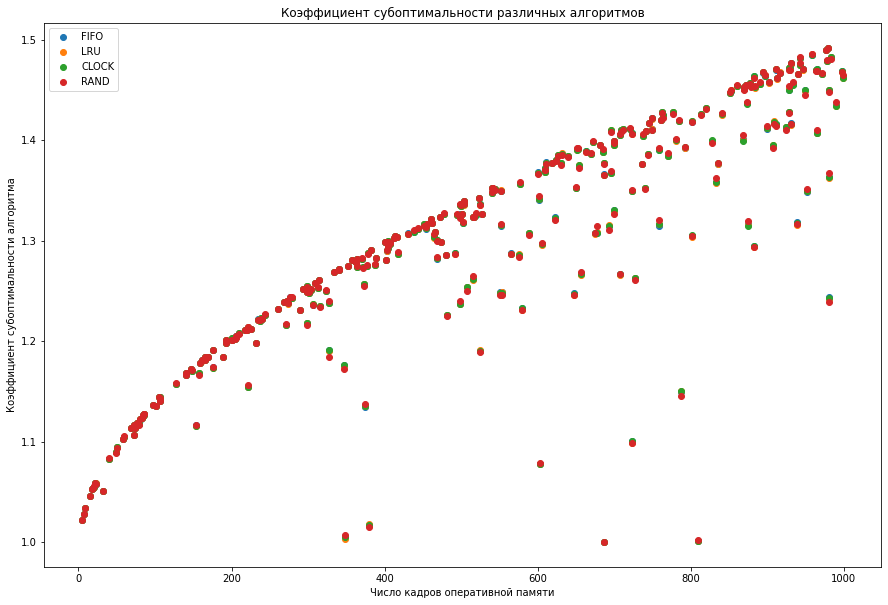

In [6]:
plt.subplots(figsize=(15,10))
plt.plot(df['num frames'], df['FIFO errors'] / df['OPT errors'], 'o', label='FIFO')
plt.plot(df['num frames'], df['LRU errors'] / df['OPT errors'], 'o', label='LRU')
plt.plot(df['num frames'], df['CLOCK errors'] / df['OPT errors'], 'o', label='CLOCK')
plt.plot(df['num frames'], df['RAND errors'] / df['OPT errors'], 'o', label='RAND')
plt.legend()
plt.xlabel('Число кадров оперативной памяти')
plt.ylabel('Коэффициент субоптимальности алгоритма')
plt.title('Коэффициент субоптимальности различных алгоритмов')
plt.show()

Также существует теорема, говорящая о том, что алгоритм случайного замещения имеет коэффициент субоптимальности $O(\log(\text{num_frames}))$. Т.к. на прошлом графике алгоритмы вели себя одинаково, посмотрим, как они поведут себя, если коэффициент субоптимальности поделить на логарифм. При этом откинем малые значения, чтобы лучше аппроксимировать сходимость.

В целом, из графика ниже можно сделать вывод, что коэффициент субоптимальности можно оценить по формуле $c \cdot \log(\text{num_frames})$, где $c \in [0.2, 0.22]$.

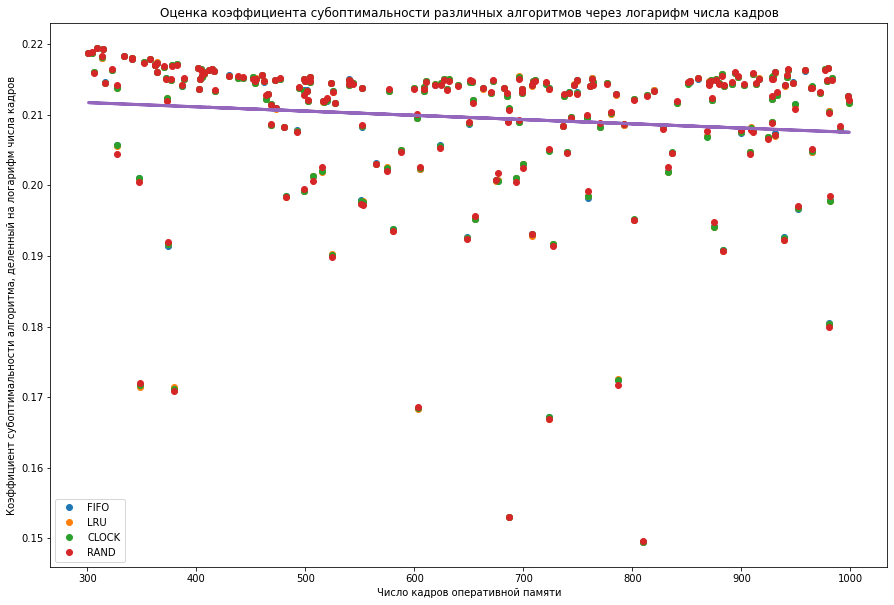

In [7]:
plt.subplots(figsize=(15,10))
df_copy = df
df = df[df['num frames'] > 300]
plt.plot(df['num frames'], df['FIFO errors'] / df['OPT errors'] / np.log(df['num frames']), 'o', label='FIFO')
plt.plot(df['num frames'], df['LRU errors'] / df['OPT errors'] / np.log(df['num frames']), 'o', label='LRU')
plt.plot(df['num frames'], df['CLOCK errors'] / df['OPT errors'] / np.log(df['num frames']), 'o', label='CLOCK')
plt.plot(df['num frames'], df['RAND errors'] / df['OPT errors'] / np.log(df['num frames']), 'o', label='RAND')

trendline = np.polyfit(df['num frames'], df['RAND errors'] / df['OPT errors'] / np.log(df['num frames']), 1)
p = np.poly1d(trendline)
plt.plot(df['num frames'], p(df['num frames']), linewidth=3)

plt.legend()
plt.xlabel('Число кадров оперативной памяти')
plt.ylabel('Коэффициент субоптимальности алгоритма, деленный на логарифм числа кадров')
plt.title('Оценка коэффициента субоптимальности различных алгоритмов через логарифм числа кадров')
plt.show()

df = df_copy

Еще один важный для анализа вопрос -- скорость работы алгоритмов. Посмотрим, как она зависит от числа страничных запросов. В целом, видно, что все алгоритмы на случайных данных имеют линейное время работы. Хотя алгоритмы LRU и OPT все же имеют алгоритмическую сложность $O(n \log n)$, где $n$ --  число страничных запросов. Они то и показали худший результат по времени, что объясняется их асимптотикой. 

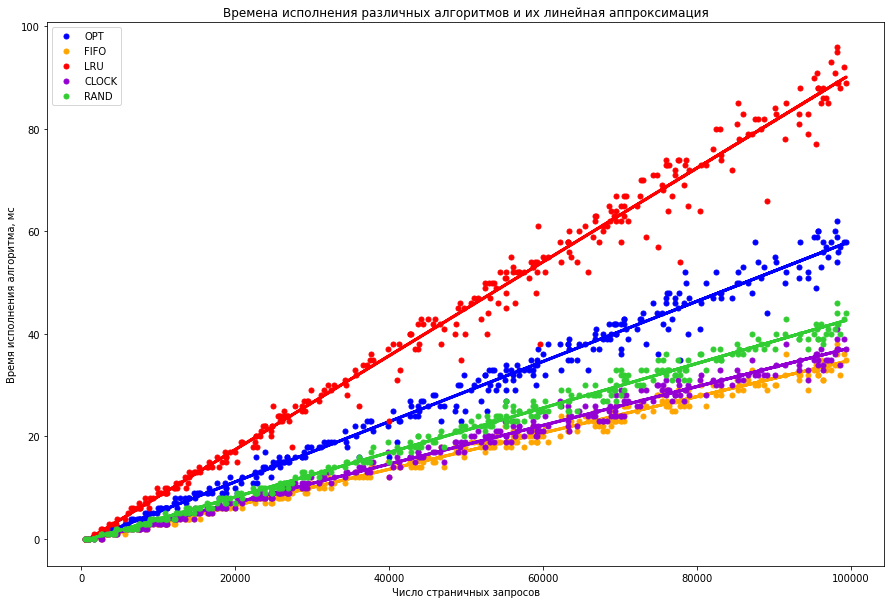

In [8]:
def plot(time_usage, label, color):
    axes.plot(df['num requests'], time_usage, 'o', label=label, markersize=5, color=color)
    trendline = np.polyfit(df['num requests'], time_usage, 1)
    p = np.poly1d(trendline)
    axes.plot(df['num requests'], p(df['num requests']), color=color, linewidth=3)

_, axes = plt.subplots(1, 1, figsize=(15, 10))
plot(df['OPT time'], 'OPT', 'blue')
plot(df['FIFO time'], 'FIFO', 'orange')
plot(df['LRU time'], 'LRU', 'red')
plot(df['CLOCK time'], 'CLOCK', 'darkviolet')
plot(df['RAND time'], 'RAND', 'limegreen')
axes.legend()
axes.set_xlabel('Число страничных запросов')
axes.set_ylabel('Время исполнения алгоритма, мс')
axes.set_title('Времена исполнения различных алгоритмов и их линейная аппроксимация')
plt.show()

Так какой же алгоритм все-таки выбрать? Проведем статистический тест. Сравним каждый алгоритм с каждым и выясним, в каком проценте случаев один показал не больше ошибок, чем другой. Построим для этих величин доверительные интервалы. Итоговые результаты можно видеть в таблице ниже. В ячейке (i, j) таблицы показано, в каком проценте случаев алгоритм i выдает меньше ошибок страничных, чем алгоритм j.

In [22]:
def get_interval(i, j):
    a1 = df[arr[i] + " errors"].to_numpy()
    a2 = df[arr[j] + " errors"].to_numpy()
    wins = []
    for i in range(1000):
        ind = np.random.choice(a1.shape[0], 50, replace=False)
        wins.append((a1[ind] <= a2[ind]).sum() / 50)
    wins = np.array(wins)
    return f'[{int(np.quantile(wins, 0.25) * 100)}, {int(np.quantile(wins, 0.75) * 100)}]'

In [23]:
table = [["" for _ in range(4)] for _ in range(4)]
arr = ["FIFO", "LRU", "RAND", "CLOCK"]
for i in range(4):
    for j in range(4):
        table[i][j] = get_interval(i, j)

In [24]:
df_int = pd.DataFrame(table, index=arr, columns=arr)

In [25]:
display(df_int)

,FIFO,LRU,RAND,CLOCK
FIFO,"[100, 100]","[46, 54]","[48, 56]","[50, 57]"
LRU,"[56, 64]","[100, 100]","[54, 62]","[56, 64]"
RAND,"[44, 54]","[38, 48]","[100, 100]","[46, 54]"
CLOCK,"[56, 64]","[48, 57]","[50, 57]","[100, 100]"


Из таблицы видно, что все алгоритмы дают примерно одинаковое число страничных ошибок, т.к. доверительные интервалы расположились вокруг 50%. Тем не менее видно, что доверительные интервалы для алгоритма LRU лежат правее 50, следовательно, можно сделать вывод, что это лучший алгоритм из всех предложенных.

## Вывод

Сравнив алгоритмы на случайных данных, было выявлено, что число страничных ошибок слабо зависит от выбора алгоритма замещения. Лучше всех на предложенных тестах себя показал алгоритм LRU.
Однако важно помнить, что мы стремимся уменьшить число страничных ошибок с целью ускорения работы алгоритма. В то время как алгоритм LRU имеет большее асимптотическое время работы, а также показало худшее время работы на предложенных данных, нежели алгоритмы FIFO, RAND и CLOCK. 
Алгоритм CLOCK на статистическом тесте уступил лишь только алгоритму LRU, поэтому я бы рекомендовала этот алгоритм в качестве лучшего алгоритма замещения из изученных четырех, т.к. его время работы вполне конкурирует с временем работы алгоритма FIFO, который показал лучший результат по времени. В то же время алгоритм CLOCK также учитывает структуру жесткого диска, что тоже является его достоинством.